## Face_it Project

### VGG16 MODEL using the fer_merged_clean dataset!

New dataset: *merged_disgust_clean.csv*

- Here we trained a deep learning model for facial emotion recognition using VGG16 with transfer learning.
- The model was fine-tuned on a merged dataset of facial expressions, including the disgust class from an extended source.
- After preprocessing and data augmentation, the network was trained for 25 epochs with early stopping and learning rate reduction strategies.

✅ This model achieved **__% validation accuracy**.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ===================================================
# IMPORTS
# ===================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

print("✅ Libraries already imported!")

✅ Libraries already imported!


### **Load Dataset**

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/merged_disgust_clean.csv')

print("✅ Data loaded! Dataset shape:", df.shape)

df.head(3)

✅ Data loaded! Dataset shape: (38243, 2)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...


In [9]:
emotion_dict = { 0: "Angry",
                 1: "Disgust",
                 2: "Fear",
                 3: "Happy",
                 4: "Sad",
                 5: "Surprise",
                 6: "Neutral" }


#  DataFrame with emotion code, type, and count
emotion_counts = df['emotion'].value_counts().sort_index()
emotion_label = [emotion_dict[i] for i in emotion_counts.index]

summary = pd.DataFrame({ #'Emotion ID': emotion_counts.index,
                         'Emotion Label': emotion_label,
                        'Count': emotion_counts.values   })
summary

,Emotion Label,Count
0,Angry,4717
1,Disgust,4724
2,Fear,4802
3,Happy,8794
4,Sad,5912
5,Surprise,3248
6,Neutral,6046


### **Image Preprocessing**

In [10]:
# ===================================================
# IMAGE PROCESSING
# ===================================================

# Convert 'pixels' column into image arrays (48x48 grayscale → RGB)
img_array = df.pixels.apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48).astype('uint8'))
img_array = np.stack(img_array, axis=0)
print("- Grayscale array shape:", img_array.shape)

# Convert to RGB
img_features = np.stack([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in img_array])
print("- RGB image shape:", img_features.shape)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['emotion'])
y = to_categorical(y_encoded)
print("- Labels shape:", y_encoded.shape)

- Grayscale array shape: (38243, 48, 48)
- RGB image shape: (38243, 48, 48, 3)
- Labels shape: (38243,)


### **Data Split**

In [11]:
# ===================================================
# TRAIN / VALIDATION SPLIT
# ===================================================

X_train, X_valid, y_train, y_valid = train_test_split( img_features,
                                                       y,
                                                       test_size=0.2,
                                                       stratify=y,
                                                       random_state=42
                                                       )

### **Preprocessing**

In [12]:
# ===================================================
# PREPROCESS FOR VGG16
# ===================================================

X_train = preprocess_input(X_train.astype('float32'))
X_valid = preprocess_input(X_valid.astype('float32'))

num_classes = y_train.shape[1]

In [13]:
num_classes

7

### **Model Architecture**

In [14]:
# ====================================
#  MODEL INITIALIZATION (VGG16)
# ====================================

def initialize_model():

  # Load VGG16 base model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

  # Freeze all layers (default)
  #base_model.trainable = False

  # Optional: Unfreeze some VGG16 layers
  # for layer in base_model.layers[:-4]:  # freeze all but last 4 conv layers
  #     layer.trainable = False

  output = Dense(num_classes, activation='softmax')(GlobalAveragePooling2D()(base_model.layers[-2].output))
  model = Model( inputs=base_model.input, outputs=output)

  return model

In [15]:
model = initialize_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

### **Data Augmentation**

In [16]:
# ===================================================
# DATA AUGMENTATION
# ===================================================

es = EarlyStopping( monitor='val_accuracy',
                    min_delta=1e-5,
                    patience=10,
                    verbose=1,
                    restore_best_weights=True )

lr_scheduler = ReduceLROnPlateau( monitor='val_accuracy',
                                  factor=0.5,
                                  patience=5,
                                  min_lr=1e-7,
                                  verbose=1 )

callbacks = [es, lr_scheduler]

train_datagen = ImageDataGenerator( preprocessing_function=None,  # already preprocessed
                                    rotation_range=15,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    shear_range=0.15,
                                    zoom_range=0.15,
                                    horizontal_flip=True
                                  )

train_datagen.fit(X_train)

In [17]:
# ====================================
#   COMPILE MODEL
# ====================================

def compile_model(model):

    model.compile( loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-4), #tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
                   metrics=['accuracy']
                   )
    return model

### **Fine-tuning the Model**

In [13]:
# ===================================
#  TRAINING --> Turn on the GPU here!
# ====================================

model = initialize_model()
model = compile_model(model)

batch_size = 32
epochs = 25

history = model.fit( train_datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=(X_valid, y_valid),
                     steps_per_epoch= int(len(X_train) // batch_size),
                     epochs=epochs,
                     callbacks=callbacks
                   )

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


956/956 ━━━━━━━━━━━━━━━━━━━━ 84s 72ms/step - accuracy: 0.2565 - loss: 2.0166 - val_accuracy: 0.4442 - val_loss: 1.4692 - learning_rate: 1.0000e-04
Epoch 2/25
  1/956 ━━━━━━━━━━━━━━━━━━━━ 53s 56ms/step - accuracy: 0.3125 - loss: 1.7454

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


956/956 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3125 - loss: 1.7454 - val_accuracy: 0.4411 - val_loss: 1.4631 - learning_rate: 1.0000e-04
Epoch 3/25
956/956 ━━━━━━━━━━━━━━━━━━━━ 65s 67ms/step - accuracy: 0.4705 - loss: 1.4164 - val_accuracy: 0.5079 - val_loss: 1.2964 - learning_rate: 1.0000e-04
Epoch 4/25
956/956 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3750 - loss: 1.4031 - val_accuracy: 0.5197 - val_loss: 1.2717 - learning_rate: 1.0000e-04
Epoch 5/25
956/956 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.5221 - loss: 1.2895 - val_accuracy: 0.5640 - val_loss: 1.1839 - learning_rate: 1.0000e-04
Epoch 6/25
956/956 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5625 - loss: 1.2465 - val_accuracy: 0.5568 - val_loss: 1.1888 - learning_rate: 1.0000e-04
Epoch 7/25
956/956 ━━━━━━━━━━━━━━━━━━━━ 76s 67ms/step - accuracy: 0.5524 - loss: 1.2001 - val_accuracy: 0.5623 - val_loss: 1.1804 - learning_rate: 1.0000e-04
Epoch 8/25
956/956 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.562

In [19]:
# ===================================================
# EVALUATION
# ===================================================
val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose=0)

print(f"\n✅ Validation Accuracy: {val_acc * 100:.2f}%")



✅ Validation Accuracy: 64.71%


### **Visualizing our results**

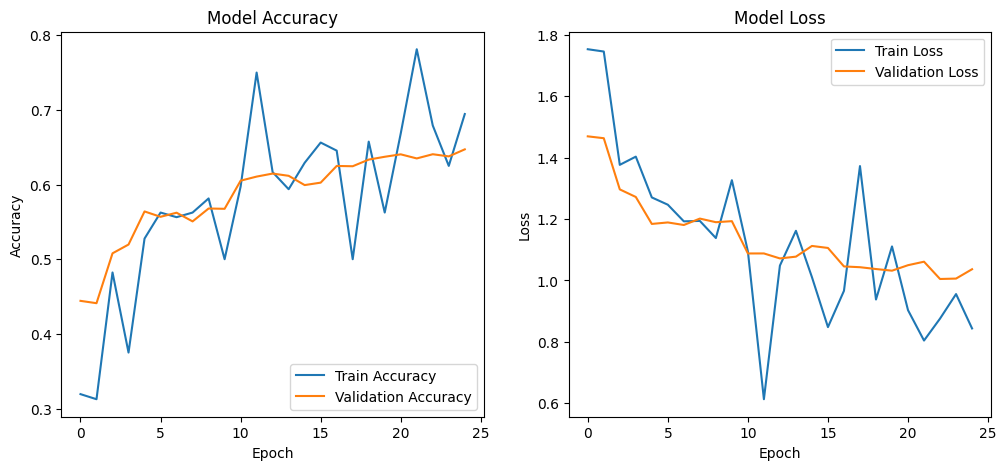

In [20]:
# ====================================
#  PLOTTING
# ====================================

plt.figure(figsize=(12,5))

# ACCURACY
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# LOSS
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


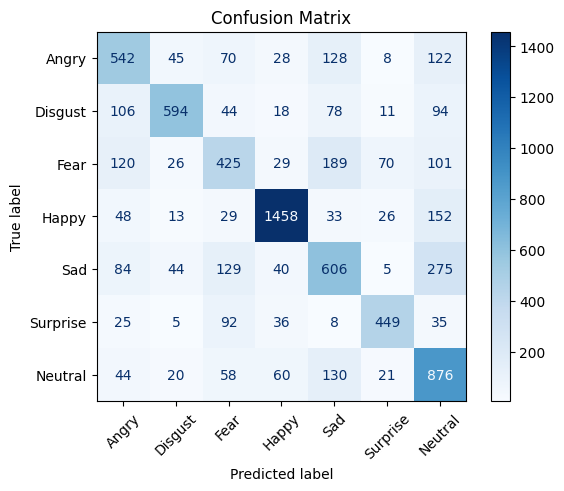

In [21]:
# ====================================
#  CONFUSION MATRIX
# ====================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on validation set
y_pred_probs = model.predict(X_valid)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_valid, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display with sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(emotion_dict.values()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


### Key Insights

**Strong Classes (well recognized)**:
- Happy (Row 4): Almost all samples (1,567) are correctly classified as Happy. This is your strongest class.
- Disgust (Row 2): Most predictions (682) fall correctly into Disgust, though there’s some confusion with Sad and Angry.
- Surprise (Row 6) and Neutral (Row 7): Both are also fairly strong, with high correct counts (595 and 812).

**Weak / Confused Classes**
- Fear (Row 3): Only ~322 correct, but many are misclassified as Sad (250), Neutral (97), and Surprise (84).



---

### **Model 2 - Adding some improvements**

Key differences from Model 1 to Model 2:
- Epochs: from 25 to 50
- Model 2: added a dropout(0.5)

In [2]:
def initialize_model_2():

  # Load VGG16 base model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

  # Freeze all layers (default)
  #base_model.trainable = False

  # Optional: Unfreeze some VGG16 layers
  # for layer in base_model.layers[:-4]:  # freeze all but last 4 conv layers
  #     layer.trainable = False

  #output = Dense(num_classes, activation='softmax')(GlobalAveragePooling2D()(base_model.layers[-2].output))
  output =  Dense(num_classes, activation='softmax')(Dropout(0.5)(GlobalAveragePooling2D()(base_model.layers[-2].output)))

  model_2 = Model( inputs=base_model.input, outputs=output)

  return model_2

In [3]:
model_2 = initialize_model_2()
model_2.summary()

NameError: name 'VGG16' is not defined

In [20]:
# ====================================
#   COMPILE MODEL
# ====================================

def compile_model(model_2):

    model_2.compile( loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-4), #tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
                   metrics=['accuracy']
                   )

    return model_2

In [21]:
model_2 = initialize_model_2()
model_2 = compile_model(model_2)

batch_size = 32
epochs = 50

history = model_2.fit( train_datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=(X_valid, y_valid),
                     steps_per_epoch= int(len(X_train) // batch_size),
                     epochs=epochs,
                     callbacks=callbacks
                   )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
122/956 ━━━━━━━━━━━━━━━━━━━━ 49:35 4s/step - accuracy: 0.1898 - loss: 2.8858

KeyboardInterrupt: 

In [25]:
# ===================================================
# EVALUATION
# ===================================================
val_loss, val_acc = model_2.evaluate(X_valid, y_valid, verbose=0)

print(f"\n✅ Model 2 - Validation Accuracy: {val_acc * 100:.2f}%")


✅ Model 2 - Validation Accuracy: 66.31%


---

## **Model 3 - new improvements**

- Trying with 100 epochs now
- This time I unfroze the last 4 layers of VGG

In [28]:
def initialize_model_3():

  # Load VGG16 base model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

  # Unfreeze the last 4 layers of VGG16 (fine-tune block5)
  for layer in base_model.layers[:-4]:
        layer.trainable = False
  for layer in base_model.layers[-4:]:
        layer.trainable = True

  output =  Dense(num_classes, activation='softmax')(Dropout(0.5)(GlobalAveragePooling2D()(base_model.layers[-2].output)))

  model_3 = Model( inputs=base_model.input, outputs=output)

  return model_3

In [29]:
model_3 = initialize_model_3()
model_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 7,083,015 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [30]:
def compile_model(model_3):

    model_3.compile( loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-4), #tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
                   metrics=['accuracy']
                   )

    return model_3

In [31]:
model_3 = initialize_model_3()
model_3 = compile_model(model_3)

batch_size = 32
epochs = 100

history = model_3.fit( train_datagen.flow(X_train, y_train, batch_size=batch_size),
                       validation_data=(X_valid, y_valid),
                       steps_per_epoch= int(len(X_train) // batch_size),
                       epochs=epochs,
                       callbacks=callbacks
                     )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.2127 - loss: 2.1591 - val_accuracy: 0.2331 - val_loss: 1.8639 - learning_rate: 1.0000e-04
Epoch 2/100
  1/956 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.1562 - loss: 1.9566

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


956/956 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1562 - loss: 1.9566 - val_accuracy: 0.2341 - val_loss: 1.8677 - learning_rate: 1.0000e-04
Epoch 3/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - accuracy: 0.2390 - loss: 1.8730 - val_accuracy: 0.3838 - val_loss: 1.6404 - learning_rate: 1.0000e-04
Epoch 4/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1875 - loss: 1.8614 - val_accuracy: 0.3849 - val_loss: 1.6384 - learning_rate: 1.0000e-04
Epoch 5/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.3473 - loss: 1.6945 - val_accuracy: 0.4467 - val_loss: 1.4721 - learning_rate: 1.0000e-04
Epoch 6/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3125 - loss: 1.7626 - val_accuracy: 0.4479 - val_loss: 1.4696 - learning_rate: 1.0000e-04
Epoch 7/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.4130 - loss: 1.5774 - val_accuracy: 0.4798 - val_loss: 1.3990 - learning_rate: 1.0000e-04
Epoch 8/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy:

In [32]:
val_loss, val_acc = model_3.evaluate(X_valid, y_valid, verbose=0)

print(f"\n✅ Model 3 - Validation Accuracy: {val_acc * 100:.2f}%")


✅ Model 3 - Validation Accuracy: 57.17%


---

## **Model 4 - Last one, ok?**

- Data Augmentation less aggressive: 0.1 instead of 0.15
- Back to 50 epochs
- Let's delete the unfreeze part
- LR changed to 0.00001

In [33]:
def initialize_model_4():

  # Load VGG16 base model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

  output =  Dense(num_classes, activation='softmax')(Dropout(0.5)(GlobalAveragePooling2D()(base_model.layers[-2].output)))

  model_4 = Model( inputs=base_model.input, outputs=output)

  return model_4

In [34]:
model_4 = initialize_model_4()
model_4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# ===================================================
#   NEW DATA AUGMENTATION - less aggr
# ===================================================
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator( preprocessing_function=preprocess_input,
                                    rotation_range=15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True
                                  )

train_datagen.fit(X_train)

In [37]:
def compile_model(model_4):

    model_4.compile( loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-5), #tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
                   metrics=['accuracy']
                   )
    return model_4

In [ ]:
model_4 = initialize_model_4()
model_4 = compile_model(model_4)

batch_size = 32
epochs = 50

history = model_4.fit( train_datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=(X_valid, y_valid),
                     steps_per_epoch= int(len(X_train) // batch_size),
                     epochs=epochs,
                     callbacks=callbacks )

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


956/956 ━━━━━━━━━━━━━━━━━━━━ 78s 73ms/step - accuracy: 0.2080 - loss: 2.8010 - val_accuracy: 0.3259 - val_loss: 1.7757 - learning_rate: 1.0000e-05
Epoch 2/50
  1/956 ━━━━━━━━━━━━━━━━━━━━ 55s 58ms/step - accuracy: 0.2812 - loss: 1.7496

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


956/956 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2812 - loss: 1.7496 - val_accuracy: 0.3266 - val_loss: 1.7773 - learning_rate: 1.0000e-05
Epoch 3/50
956/956 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step - accuracy: 0.3362 - loss: 1.7023 - val_accuracy: 0.4069 - val_loss: 1.5932 - learning_rate: 1.0000e-05
Epoch 4/50
956/956 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1875 - loss: 2.0070 - val_accuracy: 0.4091 - val_loss: 1.5907 - learning_rate: 1.0000e-05
Epoch 5/50
956/956 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - accuracy: 0.4152 - loss: 1.5642 - val_accuracy: 0.4588 - val_loss: 1.4933 - learning_rate: 1.0000e-05
Epoch 6/50
956/956 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4375 - loss: 1.5982 - val_accuracy: 0.4591 - val_loss: 1.4898 - learning_rate: 1.0000e-05
Epoch 7/50
703/956 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.4473 - loss: 1.4801

❌ No GPU available anymore. So, breaking it.

---

### Let's stick to our **MODEL 2**!

Predicting using MODEL 2 with new image already in the Drive:

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

img_path = '/content/drive/MyDrive/Colab Notebooks/test_img_1.png'

# Load and resize to 48x48 (the size all my models were trained on)
img = image.load_img(img_path, target_size=(48, 48))
img_array = image.img_to_array(img)   # shape (48,48,3)
img_array = np.expand_dims(img_array, axis=0)  # shape (1,48,48,3)

# Apply same preprocessing used in training
img_array = preprocess_input(img_array)

# Then, finally let's PREDICT on model_2
predictions = initialize_model_2.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

print(f"Predicted class index: {predicted_class}")

NameError: name 'initialize_model_2' is not defined